# Práctica 4: Regresión Logística Multi-Clase y R.N
### Autor: Daniel Herce Cruz
### Versión 1.0
### Fecha: 22-2-2024

---


## Configuración

In [11]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab") 
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Load data from https://www.openml.org/
dataset = "mnist_784"
X, y = fetch_openml(dataset, version=1, return_X_y=True, as_frame=False, parser="pandas")
X = X / 255.0  # Escalar los datos entre 0 y 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

# Mostramos la cantidad de datos por clase
print(pd.Series(y_train).value_counts().sort_index())

X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


## Métricas de evaluación

In [ ]:
results = pd.DataFrame() # Variable global para guardar la tabla de resultados

In [49]:
from sklearn.metrics import accuracy_score, f1_score
## Función para añadir las métricas de un modelo a la tabla de resultados
def addMetricsToResults(label, y_train, y_train_pred, y_test, y_test_pred, train_time='-', results_var=None, displayMetric=True):
    """
    Función que añade las métricas de un modelo a la tabla de resultados global o 
    a la tabla que se le pase como argumento.

    Parámetros:
    - label: Etiqueta para identificar el modelo.
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_train_pred: Valores predichos por el modelo para el conjunto de entrenamiento.
    - y_test: Valores reales del conjunto de prueba.
    - y_test_pred: Valores predichos por el modelo para el conjunto de prueba.
    - results_var: Tabla de resultados a la que añadir las métricas. Si no se pasa, se añaden a la tabla global.
    - displayMetric: Si es True, muestra las métricas por pantalla.

    Retorna:
    No retorna ningún valor, pero agrega una fila con las métricas calculadas a la tabla de resultados global.
    """
    global results
    
    next_res = pd.DataFrame(
        {"Label": label,
        "accuracy_train": accuracy_score(y_train, y_train_pred),
        "f1_train": f1_score(y_train, y_train_pred, average="weighted"), 
        # average="weighted" para que calcule la media pesada, es decir, que tenga en cuenta el desbalanceo de las clases
        'train_time': train_time,

        "accuracy_test": accuracy_score(y_test, y_test_pred),
        "f1_test": f1_score(y_test, y_test_pred, average="weighted"),
        },
        
        index=[0]
    )
    
    if displayMetric:
        display(next_res)

    if results_var is not None:
        # Añadir la fila a la tabla de resultados, concat() devuelve una nueva tabla con la fila añadida
        results_var = pd.concat([results_var, next_res], ignore_index=True) #ignore_index=True para que el índice de las filas sea consecutivo y no repita valores, si es False (por defecto) el índice de las filas es el de los dataframes que se concatenanç
        return results_var
    else:
        results = pd.concat([results, next_res], ignore_index=True)

Como MNIST tiene una cantidad balanceada de datos de cada clase, se puede utilizar la accuracy como métrica de evaluación. Además se utilizará la matriz de confusión para visualizar el desempeño del modelo.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Referencia: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def show_confusion_matrix(y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap='Blues')
    disp.plot()
    plt.show()

## 1. Curvas de aprendizaje para regresión logística sin regularizar

Dibuja  las  curvas  de  aprendizaje  de  un  clasificador  por 
regresión logística sin regularizar, variando en número de muestras de entrenamiento 
entre  el  10%  y  el  100%  de  las  disponibles.  Analiza  los  resultados  y  extrae 
conclusiones. 

### 1.1 Buscar el mejor solver

Primero vamos a probar que solvers son los más adecuados para este problema. El objetivo es encontrar aquellos que convergen más rápido y que tengan un buen desempeño.
Para esto vamos a probar con una porción de los datos.

In [15]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

# Valor que toma el parámetro de regularización, cuanto más alto más regularización (penalización)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
kfolds = 5

train_f1_solvers = []
train_acc_solvers = []
val_f1_solvers = []
val_acc_solvers = []
train_time_solvers = []

In [16]:
for solver in solvers:
    print(f"Entrenando modelo con solver={solver}")
    clf = LogisticRegression(solver=solver, max_iter=1000, verbose=3, n_jobs=-1, tol=1e-2)

    t_ini = time.time()
    # Realizamos la validación cruzada y obtenemos las métricas de cada partición
    scores = cross_validate(clf, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['accuracy', 'f1_weighted'])
    t_fin = time.time()

    print("-"*20)
    print(f"Solver={solver}")
    print(f"Tiempo de entrenamiento: {(t_fin - t_ini) / kfolds} s")
    print(f"Train F1 score: {np.mean(scores['train_f1_weighted'])}")
    print(f"Train accuracy: {np.mean(scores['train_accuracy'])}")
    print(f"Validation F1 score: {np.mean(scores['test_f1_weighted'])}")
    print(f"Validation accuracy: {np.mean(scores['test_accuracy'])}")
    print("-"*20)

    # Guardamos las métricas medias de entrenamiento y validación
    train_time_solvers.append((t_fin - t_ini) / kfolds)
    train_f1_solvers.append(np.mean(scores['train_f1_weighted']))
    train_acc_solvers.append(np.mean(scores['train_accuracy']))
    val_f1_solvers.append(np.mean(scores['test_f1_weighted']))
    val_acc_solvers.append(np.mean(scores['test_accuracy']))


Entrenando modelo con solver=newton-cg


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   42.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   38.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   36.8s finished


--------------------
Solver=newton-cg
Tiempo de entrenamiento: 40.042564868927 s
Train F1 score: 0.9405653563993418
Train accuracy: 0.9406416666666667
Validation F1 score: 0.9192863193893055
Validation accuracy: 0.9194333333333333
--------------------
Entrenando modelo con solver=lbfgs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   55.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   52.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   54.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   52.1s finished


--------------------
Solver=lbfgs
Tiempo de entrenamiento: 54.53782711029053 s
Train F1 score: 0.9405737783024695
Train accuracy: 0.94065
Validation F1 score: 0.9193193139530693
Validation accuracy: 0.9194666666666667
--------------------
Entrenando modelo con solver=liblinear
[LibLinear]

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


[LibLinear]

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


[LibLinear]

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


[LibLinear]

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


[LibLinear]--------------------
Solver=liblinear
Tiempo de entrenamiento: 17.233691501617432 s
Train F1 score: 0.9268812337828498
Train accuracy: 0.9271083333333333
Validation F1 score: 0.913982207517126
Validation accuracy: 0.9142833333333333
--------------------
Entrenando modelo con solver=sag


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.5s finished


--------------------
Solver=sag
Tiempo de entrenamiento: 25.390209674835205 s
Train F1 score: 0.9390607269072968
Train accuracy: 0.9391458333333335
Validation F1 score: 0.9203503280279282
Validation accuracy: 0.9205
--------------------
Entrenando modelo con solver=saga


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   46.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   42.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   46.0s finished


--------------------
Solver=saga
Tiempo de entrenamiento: 45.67838640213013 s
Train F1 score: 0.9374999668432101
Train accuracy: 0.9375875
Validation F1 score: 0.9209895689427127
Validation accuracy: 0.9211333333333334
--------------------


In [17]:
# Mostramos los resultados
results_df = pd.DataFrame({
    'solver': solvers,
    'train_f1': train_f1_solvers,
    'train_acc': train_acc_solvers,
    'val_f1': val_f1_solvers,
    'val_acc': val_acc_solvers,
    'train_time': train_time_solvers
})
display(results_df)


,solver,train_f1,train_acc,val_f1,val_acc,train_time
0,newton-cg,0.940565,0.940642,0.919286,0.919433,40.042565
1,lbfgs,0.940574,0.940650,0.919319,0.919467,54.537827
2,liblinear,0.926881,0.927108,0.913982,0.914283,17.233692
3,sag,0.939061,0.939146,0.920350,0.920500,25.390210
4,saga,0.937500,0.937588,0.920990,0.921133,45.678386


Resultados de lo anterior:

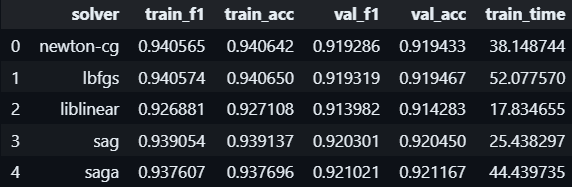

Basándonos en los resultados anteriores, se utilizará el solver 'sag' debido a que este es el segundo más rápido en converger y el que tiene la segunda mejor precisión aunque esta es practicamente igual en todos los solvers. Sin embargo, al tener un tiempo de entrenamiento menor permitirá subir la tolerancia y así mejorar la precisión.

### 1.2 Curvas de aprendizaje

In [18]:
from sklearn.linear_model import LogisticRegression
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.model_selection import LearningCurveDisplay
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html
from sklearn.model_selection import learning_curve
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

best_solver = 'sag'
kfolds = 5
learning_sizes = 10
training_sizes = np.linspace(0.1, 1.0, learning_sizes)

clf = LogisticRegression(solver=best_solver, max_iter=1000, verbose=3, n_jobs=-1, tol=1e-3)

# Mostramos la curva de aprendizaje
train_sizes_abs, train_acc, test_acc, fit_times, _ = learning_curve(
    clf, X_train, y_train, cv=kfolds, n_jobs=-1, train_sizes=training_sizes, verbose=3, return_times=True, scoring='accuracy')



[learning_curve] Training set sizes: [ 4800  9600 14400 19200 24000 28800 33600 38400 43200 48000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:  3.7min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  34 out of  50 | elapsed:  6.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.5min finished


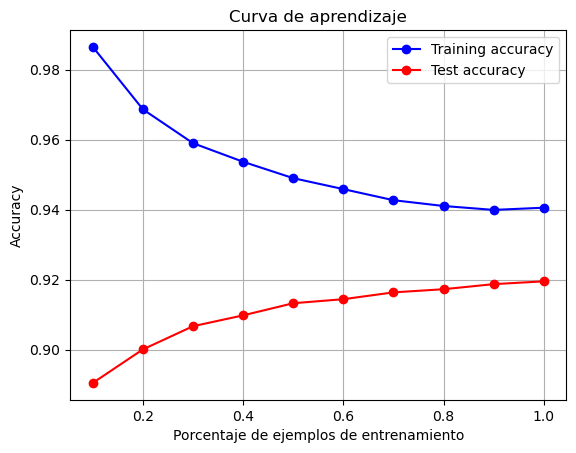

In [19]:
# No me gusta este plot por que no se aprecia a que valores convergen las curvas
# learning_curve_img = LearningCurveDisplay(train_scores=train_scores, test_scores=test_scores, train_sizes=train_sizes)
# learning_curve_img.plot()


# Vamos a hacer un plot personalizado
plt.figure()
plt.title("Curva de aprendizaje")
plt.xlabel("Porcentaje de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(training_sizes, np.mean(train_acc, axis=1), label="Training accuracy", marker='o', color="b")
plt.plot(training_sizes, np.mean(test_acc, axis=1), label="Test accuracy", marker='o', color="r")
plt.legend(loc="best")
plt.show()


In [20]:
# Entrenamos el modelo con todos los datos
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 151 epochs took 134 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242


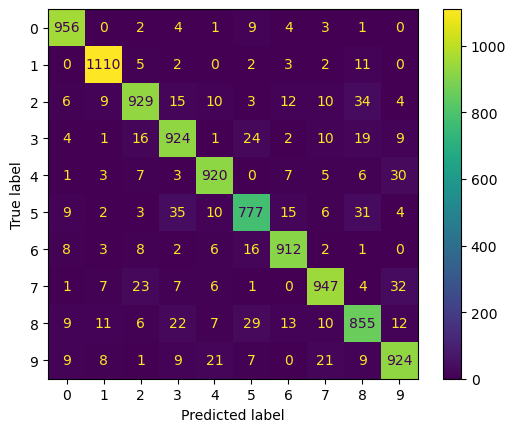

In [21]:
# Predecimos los valores de entrenamiento y prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("LogisticRegression_" + best_solver, y_train, y_train_pred, y_test, y_test_pred, t2 - t1)

show_confusion_matrix(y_test, y_test_pred)

### 1.3 Discusión de resultados

In [22]:
results

,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242


Podemos observar que conforme el Training Size aumenta también lo hace la precisión del modelo, esto es debido a que el modelo tiene más datos para entrenar y por lo tanto puede generalizar mejor. Se observa una diferencia entre las métricas de entrenamiento y validación, por lo que se está presentando un poco de sobreajuste. Esta diferencia disminuye conforme el tamaño de entrenamiento aumenta ya que el modelo tiene más datos para entrenar y por lo tanto puede generalizar mejor.

Es destacable que se ha utilizado el solver sag ya que es el que mejor desempeño ha tenido en el menor tiempo.

## 2. Regresión logística

A continuación entrenaremos un modelo utilizando regresión logística que clasifique los caracteres lo mejor posible.

### 2.1 Buscamos el mejor valor de regularización

In [23]:
lambda_values = np.logspace(-20, 10, 10)

kfolds = 4
solver = 'sag'
tol = 1e-2
penalty = 'l2'

train_f1 = []
train_acc = []
val_f1 = []
val_acc = []

print("lambda_values:", lambda_values)

lambda_values: [1.00000000e-20 2.15443469e-17 4.64158883e-14 1.00000000e-10
 2.15443469e-07 4.64158883e-04 1.00000000e+00 2.15443469e+03
 4.64158883e+06 1.00000000e+10]


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate


for lambda_val in lambda_values:
    print(f"Entrenando modelo con lambda={lambda_val}")
    clf = LogisticRegression(solver=solver, max_iter=1000, verbose = 3, n_jobs=-1, tol=tol, penalty=penalty, C=1/lambda_val)

    scores = cross_validate(clf, X_train, y_train, cv=kfolds, return_train_score=True, scoring=['accuracy', 'f1_weighted'])

    train_f1.append(np.mean(scores['train_f1_weighted']))
    train_acc.append(np.mean(scores['train_accuracy']))
    val_f1.append(np.mean(scores['test_f1_weighted']))
    val_acc.append(np.mean(scores['test_accuracy']))

Entrenando modelo con lambda=1e-20


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.2s finished


Entrenando modelo con lambda=2.1544346900318778e-17


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   32.9s finished


Entrenando modelo con lambda=4.6415888336127915e-14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.1s finished


Entrenando modelo con lambda=1e-10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   34.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.4s finished


Entrenando modelo con lambda=2.1544346900318867e-07


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   32.9s finished


Entrenando modelo con lambda=0.00046415888336127914


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   32.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   33.4s finished


Entrenando modelo con lambda=1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.2s finished


Entrenando modelo con lambda=2154.4346900318956


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


Entrenando modelo con lambda=4641588.833612791


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished


Entrenando modelo con lambda=10000000000.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished


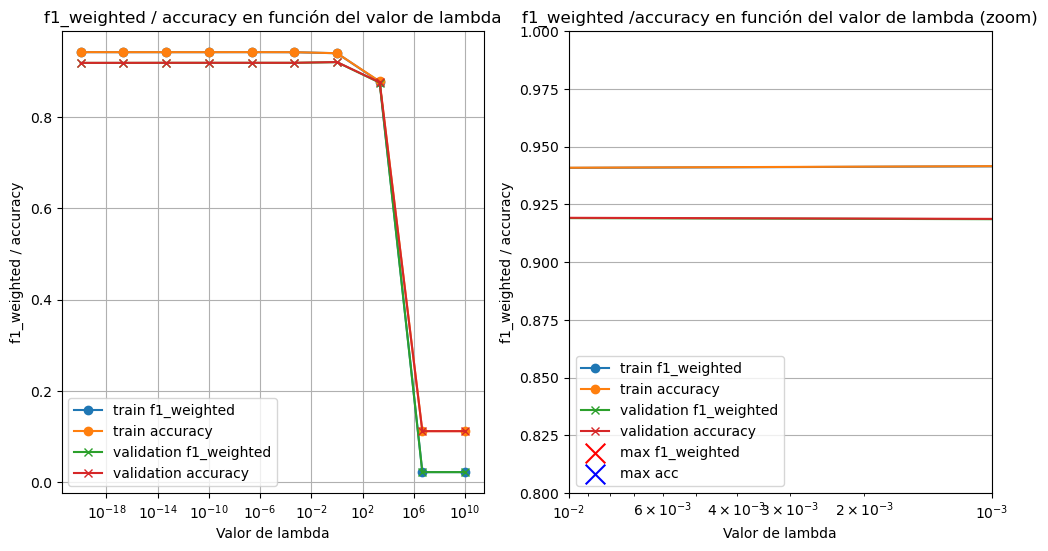

Valor de lambda que maximiza el f1_weighted score: 1.0
f1_weighted máximo: 0.9199687988348421
Valor de lambda que maximiza el accuracy: 1.0
accuracy máximo: 0.9201166666666666


In [25]:
# Mostramos la evolución de las métricas en función del valor de lambda
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(lambda_values, train_f1, label="train f1_weighted", marker='o')
ax[0].plot(lambda_values, train_acc, label="train accuracy", marker='o')
ax[0].plot(lambda_values, val_f1, label="validation f1_weighted", marker='x')
ax[0].plot(lambda_values, val_acc, label="validation accuracy", marker='x')
ax[0].set_xlabel("Valor de lambda")
ax[0].set_xscale("log")
ax[0].set_ylabel("f1_weighted / accuracy")
ax[0].set_title("f1_weighted / accuracy en función del valor de lambda")
ax[0].legend()
ax[0].grid()

# Ahora mostraremos un zoom en la zona donde se encuentra el mínimo
ax[1].plot(lambda_values, train_f1, label="train f1_weighted", marker='o')
ax[1].plot(lambda_values, train_acc, label="train accuracy", marker='o')
ax[1].plot(lambda_values, val_f1, label="validation f1_weighted", marker='x')
ax[1].plot(lambda_values, val_acc, label="validation accuracy", marker='x')
ax[1].scatter(lambda_values[np.argmax(val_f1)], max(val_f1), c='red', marker='x', label='max f1_weighted', s=200)
ax[1].scatter(lambda_values[np.argmax(val_acc)], max(val_acc), c='blue', marker='x', label='max acc', s=200)
ax[1].set_xlabel("Valor de lambda")
ax[1].set_xscale("log")
ax[1].set_ylabel("f1_weighted / accuracy")
ax[1].set_title("f1_weighted /accuracy en función del valor de lambda (zoom)")
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(1e-2, 1e-3)
ax[1].set_ylim(0.8, 1)
plt.show()

print("Valor de lambda que maximiza el f1_weighted score:", lambda_values[np.argmax(val_f1)])
print("f1_weighted máximo:", max(val_f1))
print("Valor de lambda que maximiza el accuracy:", lambda_values[np.argmax(val_acc)])
print("accuracy máximo:", max(val_acc))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 34 epochs took 30 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   30.0s finished


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag_reg,0.9381,0.938025,30.230109,0.926,0.925822


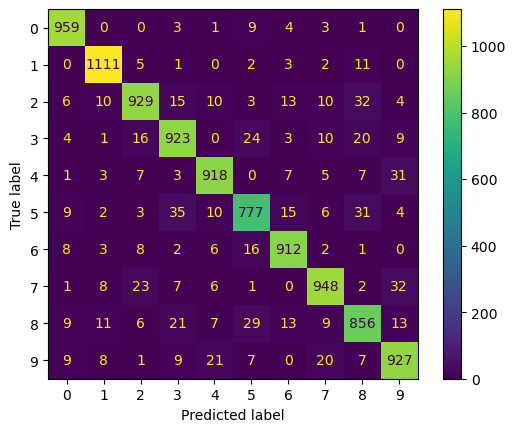

In [26]:
# Entrenamos el modelo con mejor lambda
clf = LogisticRegression(solver=solver, max_iter=1000, verbose = 3, n_jobs=-1, tol=tol, penalty=penalty, C=1/lambda_values[np.argmax(val_acc)])

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

addMetricsToResults("LogisticRegression_" + solver + "_reg", y_train, y_train_pred, y_test, y_test_pred, t2 - t1)

show_confusion_matrix(y_test, y_test_pred)

### 2.2 Discusión de resultados

In [27]:
results

,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242
1,LogisticRegression_sag_reg,0.938100,0.938025,30.230109,0.9260,0.925822


Con la curva de evaluación se ve como claramente un valor pequeño de regularización es lo mejor para el  modelo por lo que se puede intuir que la regualrización no es muy útil. ya que al regularizar el modelo ha mejorado 0.001 su precisión y con un valor de regularización mayor a 100 el modelo se subajusta.

Esto se refuerza al comparar el desempeño de este modelo con el modelo sin regularizar.

En cuanto a la precisión por clase podemos observar como el 1 es el número mejor clasificado y el 5 el peor. Esto puede ser debido a que el 1 es el número más simple y el 5 el más complejo ya que este se confunde con el 3 y el 8 principalmente. Otras confusiones habituales son el 2 con el 8, el 4 con el 9 y el 7 con el 9.

---
## 3. Perceptrón sin capa oculta

Entrenaremos una red sin capa oculta, para la clasificación multiclase. Evaluaremos con sus datos el mejor modelo obtenido y analizaremos y discutiremos los resultados.

### 3.1 Búsqueda de los mejores hiperparámetros

In [28]:
from sklearn.neural_network import MLPClassifier
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from sklearn.model_selection import GridSearchCV
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

param_grid = {
    'activation': ['logistic', 'relu'],
    'solver': ['lbfgs', 'adam'],
}

mlp_clf = MLPClassifier(hidden_layer_sizes=(), max_iter=1000, verbose=1, tol=1e-3)

# Realizamos la búsqueda de hiperparámetros
grid_search = GridSearchCV(mlp_clf, param_grid, cv=3, n_jobs=-1, verbose=1)

t_ini = time.time()
grid_search.fit(X_train, y_train)
t_fin = time.time()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Iteration 1, loss = 0.79298191
Iteration 2, loss = 0.39997968
Iteration 3, loss = 0.34347766
Iteration 4, loss = 0.31770220
Iteration 5, loss = 0.30242035
Iteration 6, loss = 0.29177240
Iteration 7, loss = 0.28426953
Iteration 8, loss = 0.27826625
Iteration 9, loss = 0.27401033
Iteration 10, loss = 0.27007081
Iteration 11, loss = 0.26685280
Iteration 12, loss = 0.26397237
Iteration 13, loss = 0.26153540
Iteration 14, loss = 0.25923992
Iteration 15, loss = 0.25768402
Iteration 16, loss = 0.25588540
Iteration 17, loss = 0.25416323
Iteration 18, loss = 0.25302433
Iteration 19, loss = 0.25178550
Iteration 20, loss = 0.25059346
Iteration 21, loss = 0.24935276
Iteration 22, loss = 0.24849659
Iteration 23, loss = 0.24753423
Iteration 24, loss = 0.24653836
Iteration 25, loss = 0.24562743
Iteration 26, loss = 0.24509989
Iteration 27, loss = 0.24434891
Iteration 28, loss = 0.24340848
Iteration 29, loss = 0.24323084
Iteration 30, loss = 

In [29]:
print(f"Tiempo de búsqueda de hiperparámetros: {t_fin - t_ini} s")

# Mostramos los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor score encontrado:")
print(grid_search.best_score_)
print("Mejor modelo encontrado:")
print(grid_search.best_estimator_)
print("Todos los resultados en formato dataframe:")
results_mlp_0 = pd.DataFrame(grid_search.cv_results_)
display(results_mlp_0) 

Tiempo de búsqueda de hiperparámetros: 23.382306575775146 s
Mejores hiperparámetros encontrados:
{'activation': 'relu', 'solver': 'adam'}
Mejor score encontrado:
0.9222333333333333
Mejor modelo encontrado:
MLPClassifier(hidden_layer_sizes=(), max_iter=1000, tol=0.001, verbose=1)
Todos los resultados en formato dataframe:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,10.768922,0.823391,0.082662,0.009286,logistic,lbfgs,"{'activation': 'logistic', 'solver': 'lbfgs'}",0.91840,0.91825,0.91945,0.918700,0.000534,3
1,14.518759,0.746631,0.047200,0.007521,logistic,adam,"{'activation': 'logistic', 'solver': 'adam'}",0.91945,0.92180,0.92445,0.921900,0.002042,2
2,10.110264,0.395555,0.098212,0.005710,relu,lbfgs,"{'activation': 'relu', 'solver': 'lbfgs'}",0.91685,0.91765,0.91950,0.918000,0.001110,4
3,14.676988,0.299683,0.050738,0.007875,relu,adam,"{'activation': 'relu', 'solver': 'adam'}",0.92100,0.92080,0.92490,0.922233,0.001887,1


### 3.2 Entrenamiento del modelo

Iteration 1, loss = 0.79388713
Iteration 2, loss = 0.40180982
Iteration 3, loss = 0.34470120
Iteration 4, loss = 0.31833237
Iteration 5, loss = 0.30278035
Iteration 6, loss = 0.29226715
Iteration 7, loss = 0.28452319
Iteration 8, loss = 0.27841343
Iteration 9, loss = 0.27379237
Iteration 10, loss = 0.26987675
Iteration 11, loss = 0.26663909
Iteration 12, loss = 0.26410789
Iteration 13, loss = 0.26137218
Iteration 14, loss = 0.25956127
Iteration 15, loss = 0.25757991
Iteration 16, loss = 0.25555490
Iteration 17, loss = 0.25450230
Iteration 18, loss = 0.25279942
Iteration 19, loss = 0.25162571
Iteration 20, loss = 0.25032662
Iteration 21, loss = 0.24938830
Iteration 22, loss = 0.24823338
Iteration 23, loss = 0.24726563
Iteration 24, loss = 0.24648331
Iteration 25, loss = 0.24600224
Iteration 26, loss = 0.24500934
Iteration 27, loss = 0.24404686
Iteration 28, loss = 0.24340223
Iteration 29, loss = 0.24285438
Iteration 30, loss = 0.24218405
Iteration 31, loss = 0.24180564
Iteration 32, los

,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,MLPClassifier_0,0.935067,0.934988,8.033869,0.9261,0.92601


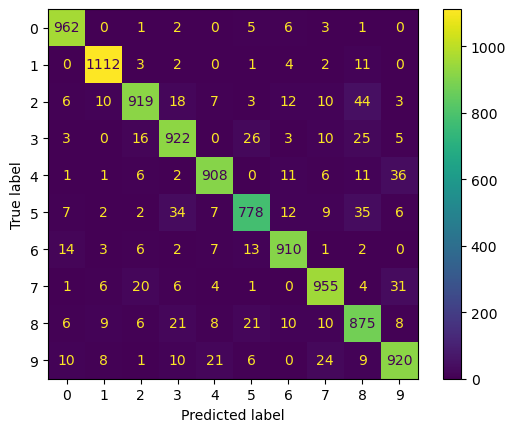

In [30]:
model = grid_search.best_estimator_

t1 = time.time()
model.fit(X_train, y_train)
t2 = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

addMetricsToResults("MLPClassifier_0", y_train, y_train_pred, y_test, y_test_pred, t2 - t1)

show_confusion_matrix(y_test, y_test_pred)


### 3.3 Discusión de resultados

In [31]:
display(results_mlp_0)
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,10.768922,0.823391,0.082662,0.009286,logistic,lbfgs,"{'activation': 'logistic', 'solver': 'lbfgs'}",0.91840,0.91825,0.91945,0.918700,0.000534,3
1,14.518759,0.746631,0.047200,0.007521,logistic,adam,"{'activation': 'logistic', 'solver': 'adam'}",0.91945,0.92180,0.92445,0.921900,0.002042,2
2,10.110264,0.395555,0.098212,0.005710,relu,lbfgs,"{'activation': 'relu', 'solver': 'lbfgs'}",0.91685,0.91765,0.91950,0.918000,0.001110,4
3,14.676988,0.299683,0.050738,0.007875,relu,adam,"{'activation': 'relu', 'solver': 'adam'}",0.92100,0.92080,0.92490,0.922233,0.001887,1


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242
1,LogisticRegression_sag_reg,0.938100,0.938025,30.230109,0.9260,0.925822
2,MLPClassifier_0,0.935067,0.934988,8.033869,0.9261,0.926010


Podemos observar como el preceptrón sin ninguna capa oculta tiene un desempeño igual al los modelos de regresión logística pero en un tiempo de entrenamiento mucho menor. Esto se debe a que el perceptrón al no tener capas ocultas es mucho más simple y por lo tanto converge más rápido.


---
## 4. Perceptrón Multicapa

A continuación buscaremos un modelo que utilice un perceptrón multicapa que clasifique los caracteres lo mejor posible.

### 4.1 Búsqueda de la mejor arquitectura

In [62]:
sizes =  [(10,), (100,) , (1000,), (10, 10), (100, 100), (1000, 1000), (100, 100, 100)]
activation = 'relu'
solver = 'adam'
mlp_clfs = {}
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
results_mlp_arch = pd.DataFrame()

In [ ]:
for size in sizes:
    mlp_clf = MLPClassifier(hidden_layer_sizes=size, max_iter=1000, activation=activation, solver=solver, verbose=1, tol=1e-3)
    t_ini = time.time()
    mlp_clf.fit(X_train, y_train)
    t_fin = time.time()

    mlp_clfs[f"MLPClassifier_{size}"] =  mlp_clf

    # Predecimos los valores de entrenamiento y prueba
    y_train_pred = mlp_clf.predict(X_train)
    y_val_pred = mlp_clf.predict(X_val)

    # Añadimos las métricas a la tabla de resultados
    results_mlp_arch = addMetricsToResults(f"MLPClassifier_{size}", y_train, y_train_pred, y_val, y_val_pred, t_fin - t_ini,  results_var=results_mlp_arch, displayMetric=True)

In [65]:
display(results_mlp_arch)

,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,"MLPClassifier_(10,)",0.979718,0.979701,13.116229,0.914802,0.914791
1,"MLPClassifier_(100,)",1.000000,1.000000,8.605099,0.959563,0.959526
2,"MLPClassifier_(1000,)",1.000000,1.000000,62.514191,0.969481,0.969474
3,"MLPClassifier_(10, 10)",0.988937,0.988929,17.307113,0.902594,0.902617
4,"MLPClassifier_(100, 100)",1.000000,1.000000,7.600924,0.961597,0.961571
5,"MLPClassifier_(1000, 1000)",1.000000,1.000000,104.679444,0.971770,0.971775
6,"MLPClassifier_(100, 100, 100)",1.000000,1.000000,8.155699,0.962869,0.962845


### 4.2 Entrenamiento del modelo

Iteration 1, loss = 0.40619208
Iteration 2, loss = 0.13285277
Iteration 3, loss = 0.07749579
Iteration 4, loss = 0.04139613
Iteration 5, loss = 0.02832326
Iteration 6, loss = 0.01721032
Iteration 7, loss = 0.01243586
Iteration 8, loss = 0.00833722
Iteration 9, loss = 0.00386223
Iteration 10, loss = 0.00209332
Iteration 11, loss = 0.00117098
Iteration 12, loss = 0.00092841
Iteration 13, loss = 0.00085690
Iteration 14, loss = 0.00081890
Iteration 15, loss = 0.00078832
Iteration 16, loss = 0.00076366
Iteration 17, loss = 0.00074392
Iteration 18, loss = 0.00072858
Iteration 19, loss = 0.00071352
Iteration 20, loss = 0.00070126
Iteration 21, loss = 0.00069014
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,MLPClassifier_best,1.0,1.0,112.933466,0.9744,0.974392


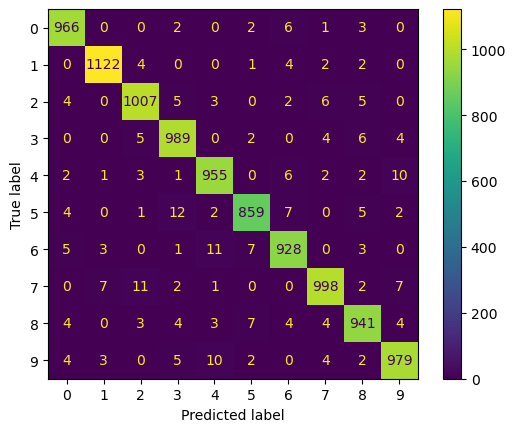

In [69]:
model = MLPClassifier(hidden_layer_sizes=(1000, 1000), max_iter=1000, activation='relu', solver='adam', verbose=1, tol=1e-3)

t1 = time.time()
model.fit(X_train, y_train)
t2 = time.time()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

addMetricsToResults("MLPClassifier_best", y_train, y_train_pred, y_test, y_test_pred, t2 - t1)

show_confusion_matrix(y_test, y_test_pred)

### 4.3 Discusión de resultados

In [67]:
display(results_mlp_arch)
display(results)

,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,"MLPClassifier_(10,)",0.979718,0.979701,13.116229,0.914802,0.914791
1,"MLPClassifier_(100,)",1.000000,1.000000,8.605099,0.959563,0.959526
2,"MLPClassifier_(1000,)",1.000000,1.000000,62.514191,0.969481,0.969474
3,"MLPClassifier_(10, 10)",0.988937,0.988929,17.307113,0.902594,0.902617
4,"MLPClassifier_(100, 100)",1.000000,1.000000,7.600924,0.961597,0.961571
5,"MLPClassifier_(1000, 1000)",1.000000,1.000000,104.679444,0.971770,0.971775
6,"MLPClassifier_(100, 100, 100)",1.000000,1.000000,8.155699,0.962869,0.962845


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242
1,LogisticRegression_sag_reg,0.938100,0.938025,30.230109,0.9260,0.925822
2,MLPClassifier_0,0.935067,0.934988,8.033869,0.9261,0.926010
3,MLPClassifier_1,0.999173,0.999173,142.395071,0.9715,0.971488


Tal y como podemos ver los perceptrones multicapa son muy superiores a los clasificadores de regresión logística y al perceptrón simple. Esto es debido a que los perceptrones multicapa son capaces de aprender relaciones no lineales entre las características y las clases. Esto, en nuestro caso con el dataset MNIST, es muy útil ya que las imágenes de los números son datos complejos y es probable que las relaciones entre las características y las clases sean no lineales.

---
## 5. Redes Convolucionales

Tras investigar el dataset MNIST, se ha observado que el modelo más adecuado para este problema es una red convolucional. Esto es debido a que las redes convolucionales son muy buenas para trabajar con imágenes y además son capaces de aprender relaciones no lineales entre las características y las clases.

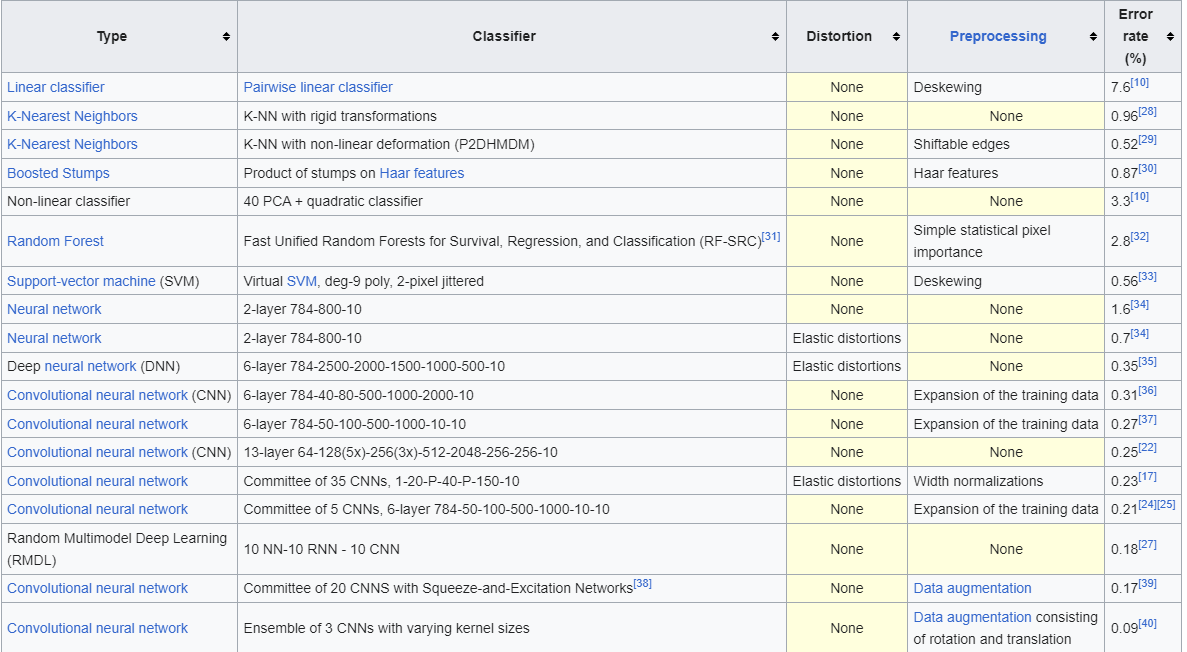

Referencia: https://en.wikipedia.org/wiki/MNIST_database

Por lo tanto se va a construir una red convolucional para clasificar los números del dataset MNIST.

In [87]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [88]:
# LOAD MNIST
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
num_pixels_mnist = img_cols * img_rows;
if K.image_data_format() == 'channels_first':
    x_train_mnist_cnn = x_train_mnist.reshape(x_train_mnist.shape[0], 1, img_rows, img_cols)
    x_test_mnist_cnn = x_test_mnist.reshape(x_test_mnist.shape[0], 1, img_rows, img_cols)
    input_shape_mnist = (1, img_rows, img_cols)
else:
    x_train_mnist_cnn = x_train_mnist.reshape(x_train_mnist.shape[0], img_rows, img_cols, 1)
    x_test_mnist_cnn = x_test_mnist.reshape(x_test_mnist.shape[0], img_rows, img_cols, 1)
    input_shape_mnist = (img_rows, img_cols, 1)

x_train_mnist_cnn = x_train_mnist_cnn.astype('float32') / 255
x_test_mnist_cnn = x_test_mnist.astype('float32') / 255

print('x_train_mnist_cnn shape:', x_train_mnist_cnn.shape)
print(x_train_mnist_cnn.shape[0], 'train samples')
print(x_test_mnist_cnn.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist, num_classes)
y_test_mnist  = tf.keras.utils.to_categorical(y_test_mnist,  num_classes)

x_train_mnist_cnn shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Para diseñar el modelo nos basaremos en el trabajo TP6 de la asignatura Inteligencia Artificial de la Universidad de Zaragoza, que también trataba de diseñar distintos modelos con el dataset MNIST.

In [89]:
# Definicion de la red convolucional
model = Sequential()
# Conv2D(number_filters, kernel_size, activation, input_shape)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape_mnist))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                      

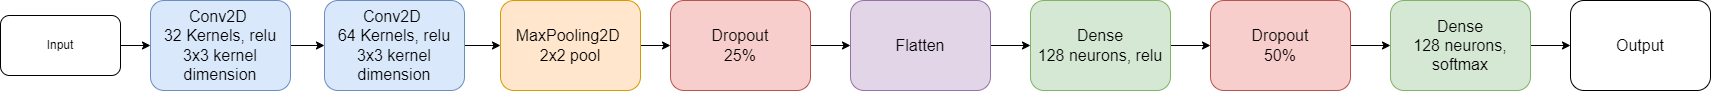

### 5.1 Entrenamiento del modelo

Epoch 1/12
422/422 [==============================] - 12s 29ms/step - loss: 0.9801 - accuracy: 0.8316 - val_loss: 0.0791 - val_accuracy: 0.9775
Epoch 2/12
422/422 [==============================] - 11s 27ms/step - loss: 0.1833 - accuracy: 0.9483 - val_loss: 0.0587 - val_accuracy: 0.9847
Epoch 3/12
422/422 [==============================] - 11s 26ms/step - loss: 0.1338 - accuracy: 0.9621 - val_loss: 0.0499 - val_accuracy: 0.9863
Epoch 4/12
422/422 [==============================] - 12s 27ms/step - loss: 0.1099 - accuracy: 0.9669 - val_loss: 0.0548 - val_accuracy: 0.9858
Epoch 5/12
422/422 [==============================] - 11s 27ms/step - loss: 0.0923 - accuracy: 0.9727 - val_loss: 0.0503 - val_accuracy: 0.9880
Epoch 6/12
422/422 [==============================] - 12s 28ms/step - loss: 0.0831 - accuracy: 0.9751 - val_loss: 0.0505 - val_accuracy: 0.9883
Epoch 7/12
422/422 [==============================] - 12s 28ms/step - loss: 0.0722 - accuracy: 0.9786 - val_loss: 0.0411 - val_accuracy:

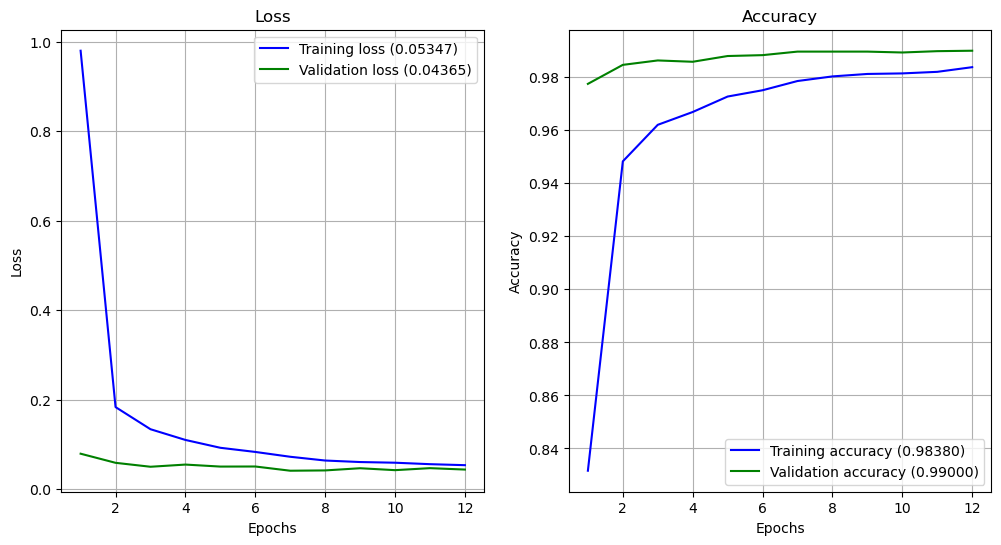

In [90]:
# Código generado con ayuda de GitHub Copilot

# Ajuste de los parámetros de la red
t1 = time.time()
history = model.fit(x_train_mnist, y_train_mnist,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True,
          validation_split=0.1)
t2 = time.time()
score = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

## As loss always exists
epochs = range(1,len(history.history[loss_list[0]]) + 1)

## Loss
fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
for l in loss_list:
    axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
for l in val_loss_list:
    axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
axs[0].grid()
axs[0].legend()

## Accuracy
for l in acc_list:
    axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
for l in val_acc_list:
    axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
axs[1].grid()
axs[1].legend()
plt.show()

313/313 [==============================] - 1s 3ms/step


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,CNN,0.9886,0.988603,-,0.9886,0.988603


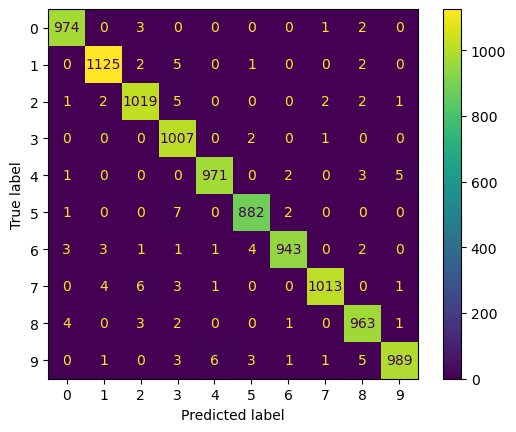

In [91]:
# Código generado con GitHub Copilot
# Mostramos la matriz de confusión
y_pred = model.predict(x_test_mnist)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_mnist, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Añadimos las métricas a la tabla de resultados
addMetricsToResults("CNN", y_true, y_pred, y_true, y_pred)

### 5.2 Discusión de resultados

Como podemos observar, este modelo es superior a todos lo anteriores al haber conseguido una precisión del 0.9908 en el conjunto de test. Esto se debe a que el modelo es capaz de aprender las características de las imágenes y clasificarlas correctamente mucho mejor que los modelos anteriores.

---
## 6. Conclusiones

In [94]:
print("Resultados de la búsqueda del mejor solver para la regresión logística")
display(results_df)
print("Resultados de la búsqueda de la mejor función de activación y solver para la red neuronal")
display(results_mlp_0)
print("Resultados de la búsqueda de la mejor arquitectura para la red neuronal")
display(results_mlp_arch)
print("Resultados finales")
display(results)

Resultados de la búsqueda del mejor solver para la regresión logística


,solver,train_f1,train_acc,val_f1,val_acc,train_time
0,newton-cg,0.940565,0.940642,0.919286,0.919433,40.042565
1,lbfgs,0.940574,0.940650,0.919319,0.919467,54.537827
2,liblinear,0.926881,0.927108,0.913982,0.914283,17.233692
3,sag,0.939061,0.939146,0.920350,0.920500,25.390210
4,saga,0.937500,0.937588,0.920990,0.921133,45.678386


Resultados de la búsqueda de la mejor función de activación y solver para la red neuronal


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,10.768922,0.823391,0.082662,0.009286,logistic,lbfgs,"{'activation': 'logistic', 'solver': 'lbfgs'}",0.91840,0.91825,0.91945,0.918700,0.000534,3
1,14.518759,0.746631,0.047200,0.007521,logistic,adam,"{'activation': 'logistic', 'solver': 'adam'}",0.91945,0.92180,0.92445,0.921900,0.002042,2
2,10.110264,0.395555,0.098212,0.005710,relu,lbfgs,"{'activation': 'relu', 'solver': 'lbfgs'}",0.91685,0.91765,0.91950,0.918000,0.001110,4
3,14.676988,0.299683,0.050738,0.007875,relu,adam,"{'activation': 'relu', 'solver': 'adam'}",0.92100,0.92080,0.92490,0.922233,0.001887,1


Resultados de la búsqueda de la mejor arquitectura para la red neuronal


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,"MLPClassifier_(10,)",0.979718,0.979701,13.116229,0.914802,0.914791
1,"MLPClassifier_(100,)",1.000000,1.000000,8.605099,0.959563,0.959526
2,"MLPClassifier_(1000,)",1.000000,1.000000,62.514191,0.969481,0.969474
3,"MLPClassifier_(10, 10)",0.988937,0.988929,17.307113,0.902594,0.902617
4,"MLPClassifier_(100, 100)",1.000000,1.000000,7.600924,0.961597,0.961571
5,"MLPClassifier_(1000, 1000)",1.000000,1.000000,104.679444,0.971770,0.971775
6,"MLPClassifier_(100, 100, 100)",1.000000,1.000000,8.155699,0.962869,0.962845


Resultados finales


,Label,accuracy_train,f1_train,train_time,accuracy_test,f1_test
0,LogisticRegression_sag,0.939217,0.939135,134.443764,0.9254,0.925242
1,LogisticRegression_sag_reg,0.938100,0.938025,30.230109,0.9260,0.925822
2,MLPClassifier_0,0.935067,0.934988,8.033869,0.9261,0.926010
3,MLPClassifier_best,1.000000,1.000000,112.933466,0.9744,0.974392
4,CNN,0.990800,0.990791,-,0.9908,0.990791


Se ha comprobado como los modelos con redes neuronales consiguen captar mejor la complejidad del problema clasificando las imágenes con un menor error que los modelos de regresión logística. Estos modelos, aunque consiguen precisiones de más del 0.9 en el conjunto de test no son tan buenos como los modelos de redes neuronales.

Además, se ha comprobado que las redes neuronales con mayor número de neuronas consiguen mejores resultados que el resto aunque ninguna de estas implementaciones ha conseguido superar la precisión de la red neuronal convolucional.